# Analysis 1: Isolation Forest & Semi-Supervised Isolation Forest

## Load Libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, average_precision_score, roc_curve, precision_recall_curve, auc, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.utils import resample
import seaborn as sns

np.random.seed(42)


# Loading Datasets

In [6]:
# Load the datasets
df_train = pd.read_csv('D_train.csv')
df_val = pd.read_csv('D_val.csv')

# Calculating & selecting correlations

In [7]:
def select_train_cols(df, target_column, threshold=0.2):
    
    # Calculate the correlation with the target variable
    label_corr = df.corr()[target_column]
    
    # Select columns with correlation above the threshold
    train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > threshold)]
    train_cols = list(train_cols.index)
    return train_cols

In [8]:
train_cols = select_train_cols(df_train, 'fraud')

# train_cols.append('Labelled')

df_train_cols = df_train[train_cols]

train_cols

['fraud',
 "'M50039827'_sum",
 "'M1888755466'_max",
 "'M1888755466'_sum",
 "'M480139044'_max",
 "'M480139044'_std",
 "'M480139044'_count",
 "'M480139044'_sum",
 "'M840466850'_sum",
 "'M1741626453'_std",
 "'M1741626453'_count",
 "'M1741626453'_sum",
 "'M1535107174'_sum",
 "'M2122776122'_max",
 "'M2122776122'_std",
 "'M2122776122'_count",
 "'M2122776122'_sum",
 "'M1873032707'_max",
 "'M1873032707'_std",
 "'M1873032707'_count",
 "'M1873032707'_sum",
 "'M2011752106'_max",
 "'M2011752106'_mean",
 "'M2011752106'_median",
 "'M2011752106'_std",
 "'M2011752106'_count",
 "'M2011752106'_sum",
 "'M857378720'_std",
 "'M857378720'_count",
 "'M857378720'_sum",
 "'M1198415165'_max",
 "'M1198415165'_count",
 "'M1198415165'_sum",
 "'M980657600'_max",
 "'M980657600'_std",
 "'M980657600'_count",
 "'M980657600'_sum",
 "'M547558035'_max",
 "'M547558035'_std",
 "'M547558035'_count",
 "'M547558035'_sum",
 "'M17379832'_max",
 "'M17379832'_std",
 "'M17379832'_count",
 "'M17379832'_sum",
 "'M923029380'_count",
 

In [9]:
num_rows = len(df_train_cols)
unlabelled_values = np.random.choice([0, 1], size=num_rows, p=[0.5, 0.5])
df_train_cols['Labelled'] = unlabelled_values
df_train_cols

/tmp/ipykernel_193848/60489751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cols['Labelled'] = unlabelled_values


,fraud,'M50039827'_sum,'M1888755466'_max,'M1888755466'_sum,'M480139044'_max,'M480139044'_std,'M480139044'_count,'M480139044'_sum,'M840466850'_sum,'M1741626453'_std,...,'es_leisure'_max,'es_leisure'_mean,'es_leisure'_median,'es_leisure'_std,'es_leisure'_count,'es_leisure'_sum,category_frequency,merchant_frequency,amount_log,Labelled
0,0,-0.193143,-0.243131,-0.229441,2.934064,-0.277417,0.211311,0.771682,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.077467,-1.919028,-0.779650,0
1,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-1.919028,0.213308,1
2,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,-0.368362,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.299356,-0.738566,1
3,0,-0.193143,-0.243131,-0.229441,3.149942,3.008618,1.214548,2.343511,5.089803,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.899603,1.075791,0.103452,1
4,0,-0.193143,6.619753,5.299477,3.816500,4.256655,3.221023,5.342679,3.180184,-0.081963,...,5.894705,4.680477,4.839599,10.151894,7.282900,8.686959,-0.392325,-0.698916,-2.129834,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356749,0,-0.193143,3.299419,2.624530,-0.386785,-0.277417,-0.290308,-0.218117,0.134384,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,0.312363,0.521195,0.975132,1
356750,1,-0.193143,0.989820,0.763856,1.345375,-0.277417,0.211311,0.298164,-0.082739,-0.081963,...,4.887399,5.221173,5.210876,-0.107288,1.678434,2.279758,-2.388939,-2.029947,2.576613,1
356751,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.614606,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.388939,-2.029947,1.109687,0
356752,0,-0.193143,-0.243131,-0.229441,-0.386785,-0.277417,-0.290308,-0.218117,1.267948,-0.081963,...,-0.246187,-0.247342,-0.247277,-0.107288,-0.189722,-0.180289,-2.271491,-2.029947,0.333940,1


# Creating Datasets per percentage fraud

In [48]:

def create_datasets(df, percentages, sample_size_normal=15000, unlabelled_normal_size=5000, random_state=42):
    datasets = {}
    
    unlabelled_fraud = df[(df['fraud'] == 1) & (df['Labelled'] == 0)]
    unlabelled_normal = df[(df['fraud'] == 0) & (df['Labelled'] == 0)]
    labelled_fraud = df[(df['fraud'] == 1) & (df['Labelled'] == 1)]
    labelled_normal = df[(df['fraud'] == 0) & (df['Labelled'] == 1)]
    
    sample_labelled_normal = labelled_normal.sample(n=sample_size_normal, random_state=random_state)
    sample_unlabelled_normal = unlabelled_normal.sample(n=unlabelled_normal_size, random_state=random_state)
    
    for p in percentages:
        size_fraud = int(len(unlabelled_fraud) * p)
        
        sample_unlabelled_fraud = unlabelled_fraud.iloc[:size_fraud]
        sample_labelled_fraud = labelled_fraud.iloc[:size_fraud]
        
        full_df = pd.concat([sample_labelled_normal, sample_unlabelled_normal, sample_unlabelled_fraud, sample_labelled_fraud])
        
        dataset_name = f'D_train_{p}p'
        datasets[dataset_name] = full_df
        
    return datasets

# Define the percentages
percentages = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011]

# Create the datasets
datasets = create_datasets(df_train_cols, percentages)

# Access the dataset for a specific percentage, e.g., 0.01
D_train_0_04p = datasets['D_train_0.004p']
D_train_0_05p = datasets['D_train_0.005p']
D_train_0_06p = datasets['D_train_0.006p']
D_train_0_07p = datasets['D_train_0.007p']
D_train_0_08p = datasets['D_train_0.008p']
D_train_0_09p = datasets['D_train_0.009p']
D_train_0_1p = datasets['D_train_0.01p']
D_train_0_11p = datasets['D_train_0.011p']

## Calculating Baseline

### Function for calculating baseline

In [12]:
def evaluate_baseline_model(df, fraud_probability):
    y_true = df['fraud']
    
    np.random.seed(42)  
    y_pred = np.random.choice([0, 1], size=len(y_true), p=[1 - fraud_probability, fraud_probability])
    
    print("Unique values in y_true after filtering:", np.unique(y_true))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    precision_values, recall_values, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall_values, precision_values)
    
    return  auc_pr, precision, recall 

### Excecute baseline per dataset

In [14]:
datasets = [D_train_0_04p, D_train_0_05p, D_train_0_06p, D_train_0_07p, D_train_0_08p, D_train_0_09p, D_train_0_1p, D_train_0_11p] #, D_train_0_6p_label, D_train_0_9p_label, D_train_1_2p_label]
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11'] #, 'D_train_0_6p', 'D_train_0_9p', 'D_train_1_2p']

results_baseline = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = evaluate_baseline_model(df_train, float(dataset_names[i]))    
    results_baseline.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
results_baseline_df = pd.DataFrame(results_baseline)

Processing dataset 1/8: 0.04
Unique values in y_true after filtering: [0 1]
Processing dataset 2/8: 0.05
Unique values in y_true after filtering: [0 1]
Processing dataset 3/8: 0.06
Unique values in y_true after filtering: [0 1]
Processing dataset 4/8: 0.07
Unique values in y_true after filtering: [0 1]
Processing dataset 5/8: 0.08
Unique values in y_true after filtering: [0 1]
Processing dataset 6/8: 0.09
Unique values in y_true after filtering: [0 1]
Processing dataset 7/8: 0.1
Unique values in y_true after filtering: [0 1]
Processing dataset 8/8: 0.11
Unique values in y_true after filtering: [0 1]


### Results Baseline

In [15]:
results_baseline_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.032258,0.001267,0.062500
1,0.05,0.051449,0.001998,0.100000
2,0.06,0.043043,0.001654,0.083333
3,0.07,0.037063,0.001399,0.071429
4,0.08,0.030828,0.001236,0.058824
5,0.09,0.027775,0.001122,0.052632
6,0.1,0.025311,0.001008,0.047619
7,0.11,0.045435,0.001819,0.086957


___

# Isolation Forest

### Algorithm to excecute Isolation Forest

parameters: n_estimators
contamination
max_samples
max_features
n_jobs
random_state

In [16]:
def train_and_evaluate_iforest(df_train, df_val):    
    # Features for training data
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_train = df_train[common_cols]
    df_val = df_val[common_cols]

    # Remove the 'fraud' column to create feature matrices
    X_train = df_train.drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']
    
    p = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    
    # # Train the Isolation Forest model
    # model = IsolationForest(contamination=p, random_state=42, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    # model.fit(X_train)

    # Train the Isolation Forest model
    model = IsolationForest(contamination=p, random_state=42) #, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    model.fit(X_train)
    
    # Predict anomaly scores (negative values indicate anomalies)
    y_pred = model.predict(X_val)
    
    # Convert IsolationForest predictions to binary outcome (1 for anomalies, 0 for normal)
    y_pred = np.where(y_pred == -1, 1, 0)  
    
    # Precision and Recall
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    # Precision-Recall AUC
    precision_values, recall_values, _ = precision_recall_curve(y_val, y_pred)
    auc_pr = auc(recall_values, precision_values)
    
    return auc_pr, precision, recall


### Excecute on every dataset with Labelled = 1 to only select the labelled instances

In [49]:
D_train_0_04p_label = D_train_0_04p[D_train_0_04p['Labelled'] == 1]
D_train_0_05p_label = D_train_0_05p[D_train_0_05p['Labelled'] == 1]
D_train_0_06p_label = D_train_0_06p[D_train_0_06p['Labelled'] == 1]
D_train_0_07p_label = D_train_0_07p[D_train_0_07p['Labelled'] == 1]
D_train_0_08p_label = D_train_0_08p[D_train_0_08p['Labelled'] == 1]
D_train_0_09p_label = D_train_0_09p[D_train_0_09p['Labelled'] == 1]
D_train_0_1p_label = D_train_0_1p[D_train_0_1p['Labelled'] == 1]
D_train_0_11p_label = D_train_0_11p[D_train_0_11p['Labelled'] == 1]

datasets = [D_train_0_04p_label,D_train_0_05p_label, D_train_0_06p_label, D_train_0_07p_label, D_train_0_08p_label, D_train_0_09p_label, D_train_0_1p_label, D_train_0_11p_label] #, D_train_0_6p_label, D_train_0_9p_label, D_train_1_2p_label]
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11'] #, 'D_train_0_6p', 'D_train_0_9p', 'D_train_1_2p']

In [18]:
results_ifo = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = train_and_evaluate_iforest(df_train, df_val)    
    results_ifo.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
results_ifo_df = pd.DataFrame(results_ifo)

Processing dataset 1/8: 0.04
Processing dataset 2/8: 0.05
Processing dataset 3/8: 0.06
Processing dataset 4/8: 0.07
Processing dataset 5/8: 0.08
Processing dataset 6/8: 0.09
Processing dataset 7/8: 0.1
Processing dataset 8/8: 0.11


### Results Isolation Forest on Validation Set

In [20]:
results_ifo_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.427923,0.725738,0.119444
1,0.05,0.367919,0.622881,0.102083
2,0.06,0.356361,0.598394,0.103472
3,0.07,0.432491,0.677249,0.177778
4,0.08,0.442100,0.681373,0.193056
5,0.09,0.445187,0.680000,0.200694
6,0.1,0.423185,0.642857,0.193750
7,0.11,0.423200,0.642202,0.194444


### Results Isolation Forest on Validation Set

Processing dataset 1/8: 0.4
Processing dataset 2/8: 0.5
Processing dataset 3/8: 0.6
Processing dataset 4/8: 0.7
Processing dataset 5/8: 0.8
Processing dataset 6/8: 0.9
Processing dataset 7/8: 1.0
Processing dataset 8/8: 1.1


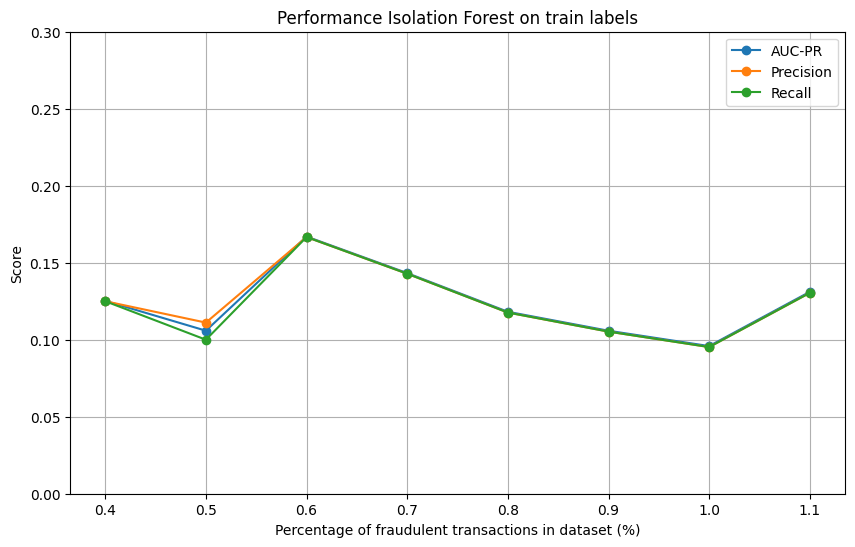

In [58]:
def train_and_evaluate_iforest(df_train, df_val):    
    # Features for training data
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_train = df_train[common_cols]
    df_val = df_val[common_cols]

    # Remove the 'fraud' column to create feature matrices
    X_train = df_train.drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']
    
    p = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    
    # # Train the Isolation Forest model
    # model = IsolationForest(contamination=p, random_state=42, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    # model.fit(X_train)

    # Train the Isolation Forest model
    model = IsolationForest(contamination=p, random_state=42) #, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    model.fit(X_train)
    
    # Predict anomaly scores (negative values indicate anomalies)
    y_pred = model.predict(X_train)
    
    # Convert IsolationForest predictions to binary outcome (1 for anomalies, 0 for normal)
    y_pred = np.where(y_pred == -1, 1, 0)  
    
    # Precision and Recall
    precision = precision_score(y_train, y_pred, zero_division=0)
    recall = recall_score(y_train, y_pred, zero_division=0)
    
    # Precision-Recall AUC
    precision_values, recall_values, _ = precision_recall_curve(y_train, y_pred)
    auc_pr = auc(recall_values, precision_values)
    
    return auc_pr, precision, recall

datasets = [D_train_0_04p_label,D_train_0_05p_label, D_train_0_06p_label, D_train_0_07p_label, D_train_0_08p_label, D_train_0_09p_label, D_train_0_1p_label, D_train_0_11p_label] #, D_train_0_6p_label, D_train_0_9p_label, D_train_1_2p_label]
dataset_names = ['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.1'] #, 'D_train_0_6p', 'D_train_0_9p', 'D_train_1_2p']

results_ifo_extra = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall = train_and_evaluate_iforest(df_train, df_val)    
    results_ifo_extra.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
results_ifo_extra_df = pd.DataFrame(results_ifo_extra)

# Plotting the results for visualization
plt.figure(figsize=(10, 6))
for i, metric in enumerate(['AUC-PR', 'Precision', 'Recall']):
    plt.plot(results_ifo_extra_df['Dataset'], results_ifo_extra_df[metric], marker='o', label=metric)
plt.title('Performance Isolation Forest on train labels')
plt.xlabel('Percentage of fraudulent transactions in dataset (%)')
plt.ylabel('Score')
plt.ylim(0,0.3)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plotting the results for visualization
plt.figure(figsize=(10, 6))
for i, metric in enumerate(['AUC-PR', 'Precision', 'Recall']):
    plt.plot(results_ifo_extra_df['Dataset'], results_ifo_extra_df[metric], marker='o', label=metric)
plt.title('Performance Isolation Forest on train labels')
plt.xlabel('Percentage of fraudulent transactions in dataset (%)')
plt.ylabel('Score')
plt.ylim(0,0.3)
plt.legend()
plt.grid(True)
plt.show()

In [54]:
results_ifo_extra_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.125233,0.125000,0.125000
1,0.05,0.105855,0.111111,0.100000
2,0.06,0.167000,0.166667,0.166667
3,0.07,0.143257,0.142857,0.142857
4,0.08,0.118146,0.117647,0.117647
5,0.09,0.105829,0.105263,0.105263
6,0.1,0.095871,0.095238,0.095238
7,0.11,0.131100,0.130435,0.130435


____

# Semi-supervised Isolation Forest

### Import the SSIF.py file

In [21]:
from SSIF import *

### Algorithm to excecute semi-supervised Isolation Forest

In [22]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
import numpy as np

def train_and_evaluate_ss_iforest(df_train, df_val, fraud_percentage):
    df_train['fraud'] = df_train.apply(lambda row: 0 if row['Labelled'] == 0 else (1 if row['fraud'] == 1 else -1), axis=1)    

    # Separate features and labels
    X_train = df_train.drop(columns=['fraud', 'Labelled'])
    y_train = df_train['fraud']

    common_columns = [col for col in X_train.columns if col in df_val.columns and col not in ['fraud', 'Labelled']]

    X_val = df_val[common_columns]
    y_val = df_val['fraud']

    # Convert to numpy arrays and use efficient data types
    X_train = X_train[common_columns].to_numpy().astype(np.float32)
    y_train = y_train.to_numpy().astype(np.int8)
    X_val = X_val.to_numpy().astype(np.float32)
    y_val = y_val.to_numpy().astype(np.int8)

    # Initialize SSIF with the correct training data
    ssif = SSIF(X_train, y_train)

    scores_val = ssif.compute_anomaly_scores(X_val)

    # Calculate the threshold based on the desired fraud percentage in the validation set
    sorted_scores = np.sort(scores_val)
    threshold_index = int((1 - fraud_percentage) * len(sorted_scores))
    threshold = sorted_scores[threshold_index]

    y_pred_val = (scores_val < threshold).astype(int)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, scores_val)
    auc_pr = auc(recall, precision)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred_val, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred_val, zero_division=0)

    return auc_pr, precision_score_val, recall_score_val, threshold


### Excecute semi-supervised Isolation Forest

In [ ]:
dataset_names = ['0.04', '0.05', '0.06', '0.07', '0.08', '0.09', '0.1' ,'0.11']
results_ss_ifo = []

# Loop through each dataset
for i, df_train in enumerate(datasets):
    print(f"Processing dataset {i+1}/{len(datasets)}: {dataset_names[i]}")
    auc_pr, precision, recall, threshold = train_and_evaluate_ss_iforest(df_train, df_val, float(dataset_names[i]) )
    # print(f"threshold {threshold}")
    results_ss_ifo.append({'Dataset': dataset_names[i], 'AUC-PR': auc_pr, 'Precision': precision, 'Recall': recall})
    
    
results_ss_ifo_df = pd.DataFrame(results_ss_ifo)

### Results semi-supervised Isolation Forest

In [25]:
results_ss_ifo_df

,Dataset,AUC-PR,Precision,Recall
0,0.04,0.406654,0.187723,0.620139
1,0.05,0.467806,0.190060,0.786111
2,0.06,0.422449,0.143217,0.709722
3,0.07,0.430971,0.135823,0.785417
4,0.08,0.453567,0.123174,0.813889
5,0.09,0.443959,0.109689,0.815278
6,0.1,0.448864,0.103179,0.852083
7,0.11,0.456559,0.095176,0.864583


----

# Final Results Analysis 1

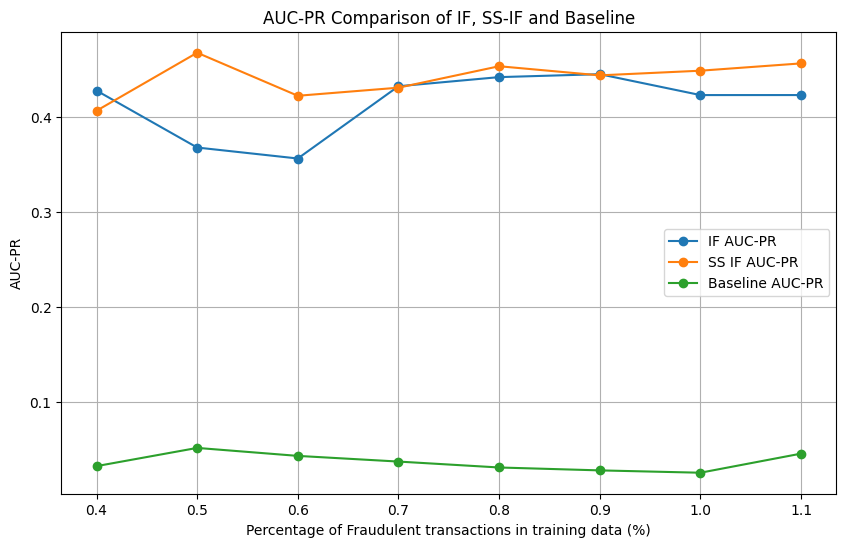

In [57]:
custom_labels = ['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.1']

# Plotting the AUC-PR results for both models in one graph
plt.figure(figsize=(10, 6))

plt.plot(results_ifo_df['Dataset'], results_ifo_df['AUC-PR'], marker='o', label='IF AUC-PR')
plt.plot(results_ss_ifo_df['Dataset'], results_ss_ifo_df['AUC-PR'], marker='o', label='SS IF AUC-PR')
plt.plot(results_baseline_df['Dataset'],results_baseline_df['AUC-PR'], marker='o', label='Baseline AUC-PR')
plt.title('AUC-PR Comparison of IF, SS-IF and Baseline')
plt.xlabel('Percentage of Fraudulent transactions in training data (%)')
plt.xticks(ticks=results_ss_ifo_df['Dataset'], labels=custom_labels)  # Adding custom x-axis labels
plt.ylabel('AUC-PR')
plt.legend()
plt.grid(True)
plt.show()

----

# Results on Test set

### Read test set

In [33]:
df_test = pd.read_csv('D_test.csv')

### Test results Isolation Forest

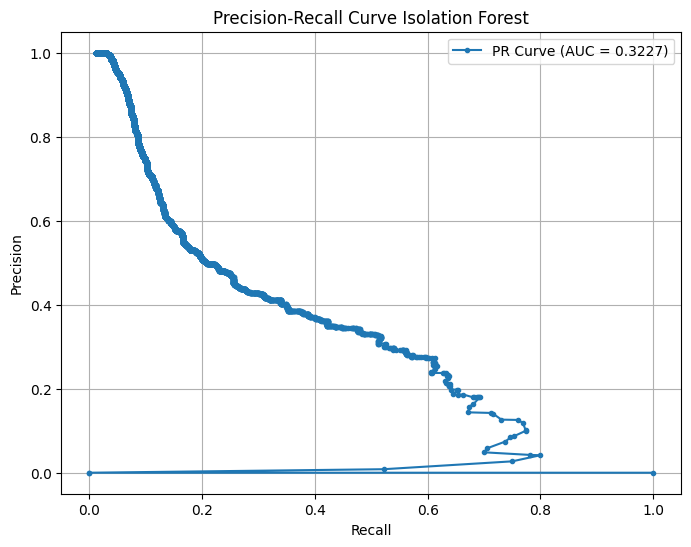

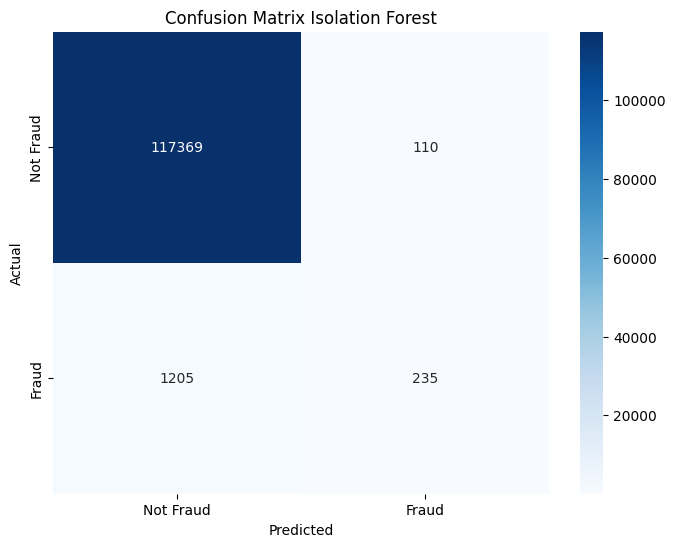

In [43]:
def train_and_evaluate_iforest(df_train, df_val):    
    # Features for training data
    common_cols = list(set(df_train.columns) & set(df_val.columns))
    df_train = df_train[common_cols]
    df_val = df_val[common_cols]

    # Remove the 'fraud' column to create feature matrices
    X_train = df_train.drop(columns=['fraud'])
    y_train = df_train['fraud']
    X_val = df_val.drop(columns=['fraud'])
    y_val = df_val['fraud']
    
    p = len(df_train[df_train['fraud'] == 1]) / len(df_train)
    
    # # Train the Isolation Forest model
    # model = IsolationForest(contamination=p, random_state=42, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    # model.fit(X_train)

    # Train the Isolation Forest model
    model = IsolationForest(contamination=p, random_state=42) #, n_estimators=200, max_samples=int(X_train.shape[0] * 0.01))
    model.fit(X_train)
    
    # Predict anomaly scores (negative values indicate anomalies)
    y_pred = model.predict(X_val)
    
    anomaly_scores = model.decision_function(X_val)
    
    # Convert IsolationForest predictions to binary outcome (1 for anomalies, 0 for normal)
    y_pred = np.where(y_pred == -1, 1, 0)  
    
    # Precision and Recall
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    # Precision-Recall AUC
    precision_values, recall_values, _ = precision_recall_curve(y_val, -anomaly_scores)
    auc_pr = auc(recall_values, precision_values)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(precision_values, recall_values, marker='.', label='PR Curve (AUC = {:.4f})'.format(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Isolation Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Isolation Forest')
    plt.show()

    
    return auc_pr, precision, recall

auc_pr, precision, recall = train_and_evaluate_iforest(D_train_0_09p, df_test)    



### Test results Semi-Supervised Isolation Forest

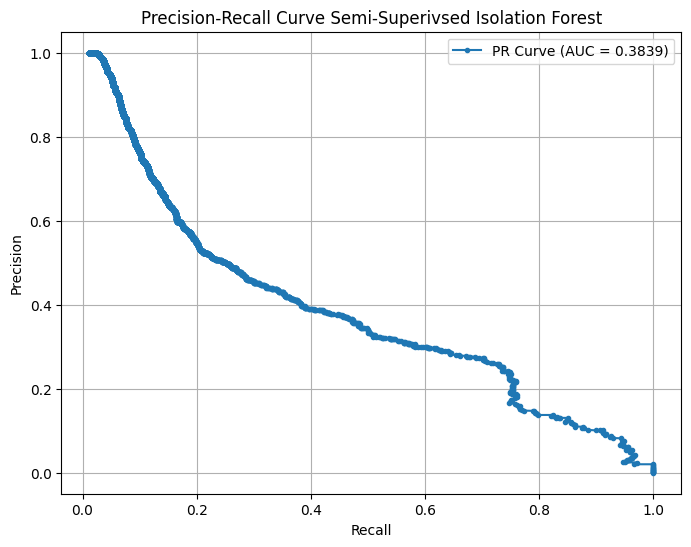

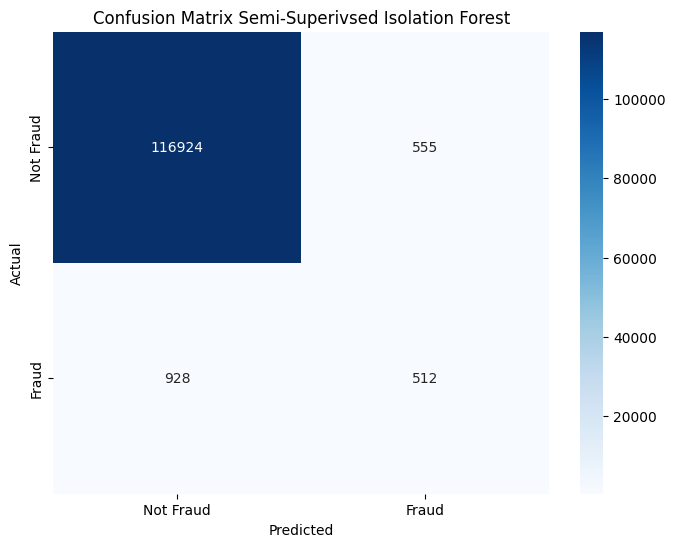

In [44]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score
import numpy as np

def train_and_evaluate_ss_iforest(df_train, df_val, fraud_percentage):
    df_train['fraud'] = df_train.apply(lambda row: 0 if row['Labelled'] == 0 else (1 if row['fraud'] == 1 else -1), axis=1)    

    # Separate features and labels
    X_train = df_train.drop(columns=['fraud', 'Labelled'])
    y_train = df_train['fraud']

    common_columns = [col for col in X_train.columns if col in df_val.columns and col not in ['fraud', 'Labelled']]

    X_val = df_val[common_columns]
    y_val = df_val['fraud']

    # Convert to numpy arrays and use efficient data types
    X_train = X_train[common_columns].to_numpy().astype(np.float32)
    y_train = y_train.to_numpy().astype(np.int8)
    X_val = X_val.to_numpy().astype(np.float32)
    y_val = y_val.to_numpy().astype(np.int8)

    # Initialize SSIF with the correct training data
    ssif = SSIF(X_train, y_train)

    scores_val = ssif.compute_anomaly_scores(X_val)

    # Calculate the threshold based on the desired fraud percentage in the validation set
    sorted_scores = np.sort(scores_val)
    threshold_index = int((1 - fraud_percentage) * len(sorted_scores))
    threshold = sorted_scores[threshold_index]

    y_pred_val = (scores_val > threshold).astype(int)

    # Calculate Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_val, scores_val)
    auc_pr = auc(recall, precision)

    # Calculate Precision and Recall
    precision_score_val = precision_score(y_val, y_pred_val, zero_division=0)
    recall_score_val = recall_score(y_val, y_pred_val, zero_division=0)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)

    # Plot Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(precision, recall, marker='.', label='PR Curve (AUC = {:.4f})'.format(auc_pr))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Semi-Superivsed Isolation Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Semi-Superivsed Isolation Forest')
    plt.show()


    return auc_pr, precision_score_val, recall_score_val, threshold

auc_pr, precision, recall, threshold = train_and_evaluate_ss_iforest(D_train_0_05p, df_test, float(0.009) )